# Import Necessary Library

In [ ]:
# importing libraries
import pandas as pd
import scipy
import numpy as np

import pickle
from os import path

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt

# Import Dataset

In [ ]:
df_raw = pd.read_csv("/content/MitM_Dataset/MitM.csv", low_memory = False)
df_raw.head()

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_invalid,frame.time_relative,ip.src,ip.dst,tcp.srcport,tcp.dstport,eth.src,...,mqtt.topic,mqtt.topic_len,mqtt.username,mqtt.username_len,mqtt.ver,mqtt.willmsg,mqtt.willmsg_len,mqtt.willtopic,mqtt.willtopic_len,type
0,0.000000,0.000000,1.529668e+09,NaN,0.000000,192.168.1.1,192.168.1.102,22.0,53940.0,18:a6:f7:eb:77:26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
1,0.000481,0.000481,1.529668e+09,NaN,0.000481,192.168.1.1,192.168.1.102,22.0,53940.0,18:a6:f7:eb:77:26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
2,0.000423,0.000423,1.529668e+09,NaN,0.000904,192.168.1.1,192.168.1.102,22.0,53940.0,18:a6:f7:eb:77:26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
3,0.000274,0.000274,1.529668e+09,NaN,0.001178,192.168.1.102,192.168.1.1,53940.0,22.0,30:5a:3a:62:72:80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
4,0.000861,0.000861,1.529668e+09,NaN,0.002039,192.168.1.102,192.168.1.1,53940.0,22.0,30:5a:3a:62:72:80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal


In [ ]:
df_raw.isnull().sum()

,0
frame.time_delta,0
frame.time_delta_displayed,0
frame.time_epoch,0
frame.time_invalid,110668
frame.time_relative,0
...,...
mqtt.willmsg,110668
mqtt.willmsg_len,110668
mqtt.willtopic,110668
mqtt.willtopic_len,110668


In [ ]:
# Drop columns with too many missing values (e.g., 50% or more)
threshold = 0.5
df = df_raw.copy()
df = df.loc[:, df.isnull().mean() < threshold]

# Impute remaining null values using median for numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Forward fill for categorical columns (if applicable)
cat_cols = df.select_dtypes(include=[object]).columns
df[cat_cols] = df[cat_cols].ffill()

In [ ]:
df['type'] = df['type'].map({'normal': 0, 'mitm': 1})


In [ ]:
# Select only numeric columns for correlation analysis
numeric_df = df.copy()
num_col = numeric_df.select_dtypes(include=[np.number]).columns
data_num = df[num_col].copy()
data_num.head()

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,frame.cap_len,frame.encap_type,frame.ignored,frame.len,frame.marked,frame.number,frame.offset_shift,type
0,0.000000,0.000000,1.529668e+09,0.000000,22.0,53940.0,134.0,1.0,0.0,134.0,0.0,1.0,0.0,0
1,0.000481,0.000481,1.529668e+09,0.000481,22.0,53940.0,150.0,1.0,0.0,150.0,0.0,2.0,0.0,0
2,0.000423,0.000423,1.529668e+09,0.000904,22.0,53940.0,118.0,1.0,0.0,118.0,0.0,3.0,0.0,0
3,0.000274,0.000274,1.529668e+09,0.001178,53940.0,22.0,66.0,1.0,0.0,66.0,0.0,4.0,0.0,0
4,0.000861,0.000861,1.529668e+09,0.002039,53940.0,22.0,66.0,1.0,0.0,66.0,0.0,5.0,0.0,0


In [ ]:
cat_col = df.columns.difference(num_col)
cat_col = cat_col[1:]
cat_col

Index(['eth.src', 'ip.dst', 'ip.src'], dtype='object')

In [ ]:
# creating a dataframe with only categorical attributes
data_cat = df_raw[cat_col].copy()
data_cat.head()

,eth.src,ip.dst,ip.src
0,18:a6:f7:eb:77:26,192.168.1.102,192.168.1.1
1,18:a6:f7:eb:77:26,192.168.1.102,192.168.1.1
2,18:a6:f7:eb:77:26,192.168.1.102,192.168.1.1
3,30:5a:3a:62:72:80,192.168.1.1,192.168.1.102
4,30:5a:3a:62:72:80,192.168.1.1,192.168.1.102


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('eth.src').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('ip.dst').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('ip.src').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('eth.src')):
  _plot_series(series, series_name, i)
  fig.legend(title='eth.src', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ip.dst')):
  _plot_series(series, series_name, i)
  fig.legend(title='ip.dst', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ip.src')):
  _plot_series(series, series_name, i)
  fig.legend(title='ip.src', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['ip.dst'].value_counts()
    for x_label, grp in _df_8.groupby('eth.src')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('eth.src')
_ = plt.ylabel('ip.dst')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['ip.src'].value_counts()
    for x_label, grp in _df_9.groupby('ip.dst')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('ip.dst')
_ = plt.ylabel('ip.src')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['eth.src'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='index', y='eth.src', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['ip.dst'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='index', y='ip.dst', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['ip.src'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='index', y='ip.src', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

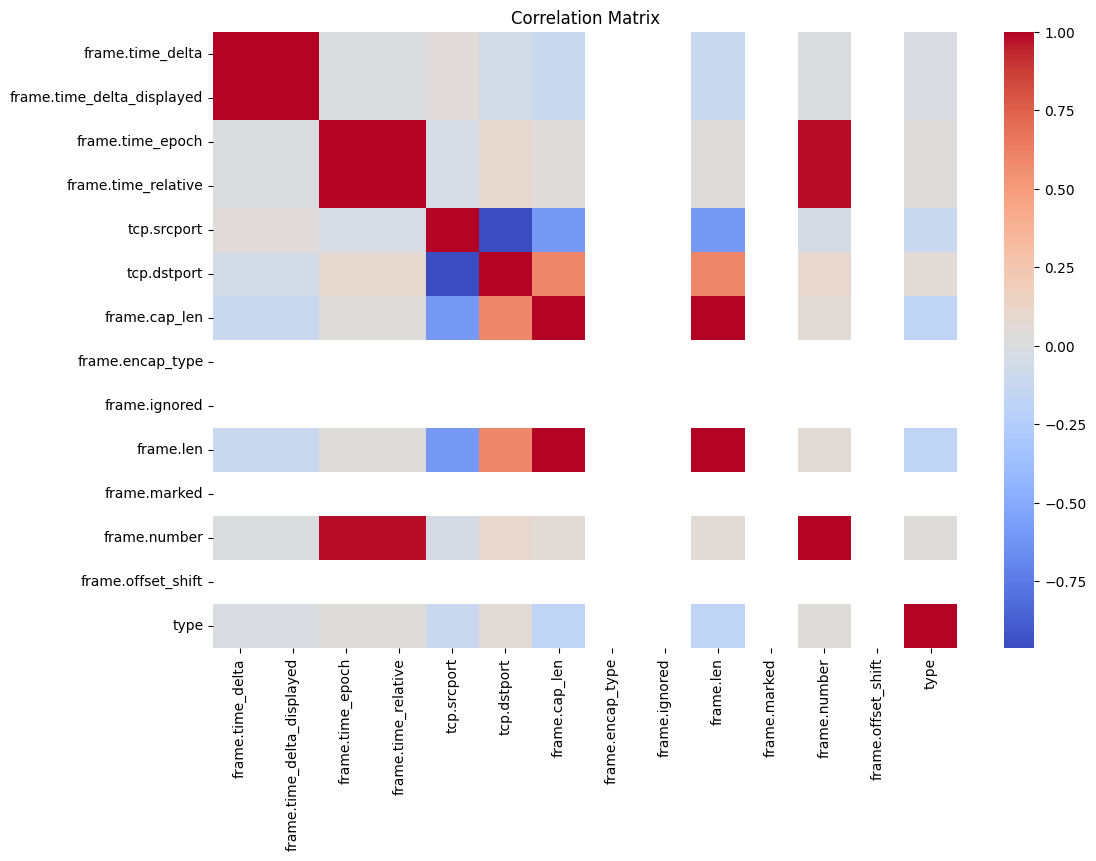

In [ ]:
# Correlation analysis for numeric features
corr_matrix = data_num.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
data_cat = pd.get_dummies(data_cat,columns=cat_col)
data_cat.head()

,eth.src_18:a6:f7:eb:77:26,eth.src_30:5a:3a:62:72:80,eth.src_48:5a:3f:93:39:9c,eth.src_4c:74:03:07:92:4f,eth.src_60:01:94:37:e0:e1,eth.src_68:c6:3a:8b:d0:1e,eth.src_74:d4:35:ed:f7:06,eth.src_74:d4:35:ef:e5:5a,eth.src_a0:20:a6:17:44:ed,eth.src_b8:27:eb:73:32:30,...,ip.src_89.255.249.53,ip.src_91.189.89.198,ip.src_91.215.103.66,ip.src_93.184.220.70,ip.src_93.93.51.190,ip.src_93.93.51.200,ip.src_93.93.53.190,ip.src_93.93.53.191,ip.src_94.23.82.225,ip.src_95.211.229.246
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df = pd.concat([df, data_cat],axis=1)

In [ ]:
df.drop(columns=cat_col,inplace=True)

# Data Normalization

In [ ]:
num_col = list(df.select_dtypes(include='number').columns)
num_col.remove('type')
num_col

['frame.time_delta',
 'frame.time_delta_displayed',
 'frame.time_epoch',
 'frame.time_relative',
 'tcp.srcport',
 'tcp.dstport',
 'frame.cap_len',
 'frame.encap_type',
 'frame.ignored',
 'frame.len',
 'frame.marked',
 'frame.number',
 'frame.offset_shift']

In [ ]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))

In [ ]:
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
  return df
df.head()

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,eth.dst,frame.cap_len,frame.encap_type,frame.ignored,...,ip.src_89.255.249.53,ip.src_91.189.89.198,ip.src_91.215.103.66,ip.src_93.184.220.70,ip.src_93.93.51.190,ip.src_93.93.51.200,ip.src_93.93.53.190,ip.src_93.93.53.191,ip.src_94.23.82.225,ip.src_95.211.229.246
0,0.000000,0.000000,1.529668e+09,0.000000,22.0,53940.0,30:5a:3a:62:72:80,134.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,0.000481,0.000481,1.529668e+09,0.000481,22.0,53940.0,30:5a:3a:62:72:80,150.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.000423,0.000423,1.529668e+09,0.000904,22.0,53940.0,30:5a:3a:62:72:80,118.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0.000274,0.000274,1.529668e+09,0.001178,53940.0,22.0,18:a6:f7:eb:77:26,66.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0.000861,0.000861,1.529668e+09,0.002039,53940.0,22.0,18:a6:f7:eb:77:26,66.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_normalization = df.copy()
df_normalization = normalization(df.copy(),num_col)
df_normalization = df_normalization.drop(columns=['eth.dst'])

In [ ]:
df_normalization['type'].value_counts()

,count
type,
0,106813
1,3855


In [ ]:
# changing attack labels into two categories 'normal' and 'mitm'
bin_label = pd.DataFrame(df_normalization.type.map(lambda x:'normal' if x==0 else 'mitm'))

In [ ]:
bin_label['type'] = bin_label['type'].map({'normal': 0, 'mitm': 1})
bin_label.value_counts()

,count
type,
0,106813
1,3855


In [ ]:
# creating a dataframe with binary labels (normal,abnormal)
bin_data = df_normalization.copy()

# Menambahkan kolom 'type' dengan bin_label
bin_data['type'] = bin_label

In [ ]:
import pandas as pd

# Contoh: Salin DataFrame normalisasi
bin_data = df_normalization.copy()

# Pastikan bin_label adalah Series atau list dengan panjang yang sesuai
if isinstance(bin_label, (list, np.ndarray)):
    bin_label = pd.Series(bin_label)

# Cek apakah panjang bin_label sama dengan bin_data
if len(bin_data) == len(bin_label):
    bin_data['type'] = bin_label
else:
    print("Panjang bin_label tidak sesuai dengan jumlah baris bin_data.")

# Menampilkan beberapa baris untuk memeriksa
print(bin_data.head())
print(bin_data.columns)  # Memeriksa semua kolom dalam bin_data

   frame.time_delta  frame.time_delta_displayed  frame.time_epoch  \
0          0.000000                    0.000000      0.000000e+00   
1          0.000049                    0.000049      1.022127e-07   
2          0.000043                    0.000043      1.920853e-07   
3          0.000028                    0.000028      2.502929e-07   
4          0.000087                    0.000087      4.332396e-07   

   frame.time_relative  tcp.srcport  tcp.dstport  frame.cap_len  \
0         0.000000e+00     0.000000     0.884525       0.076305   
1         1.021975e-07     0.000000     0.884525       0.087015   
2         1.920719e-07     0.000000     0.884525       0.065596   
3         2.502883e-07     0.884525     0.000000       0.030790   
4         4.332240e-07     0.884525     0.000000       0.030790   

   frame.encap_type  frame.ignored  frame.len  ...  ip.src_89.255.249.53  \
0               0.0            0.0   0.076305  ...                 False   
1               0.0           

In [ ]:
bin_data['type'].value_counts()

,count
type,
0,106813
1,3855


In [ ]:
# label encoding (0,1) binary labels
le1 = preprocessing.LabelEncoder()
enc_label = bin_label.apply(le1.fit_transform)
bin_data['type'] = enc_label

In [ ]:
le1.classes_

array([0, 1])

# Data Visualization

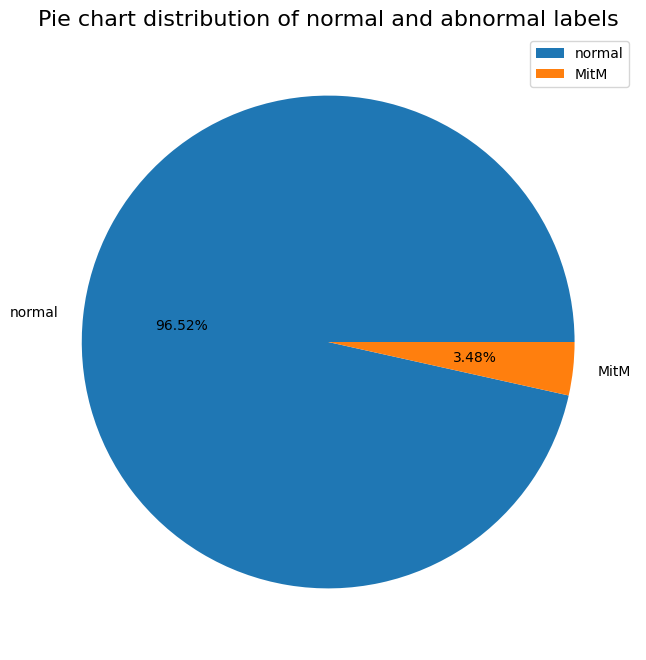

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(df_raw.type.value_counts(),labels=['normal','MitM'],autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels",fontsize=16)
plt.legend()
# plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik1_Studi Transformer-Based Sequence Modelling untuk Deteksi Ransomware Melalui Analisis Trafik Jaringan yang Mengenkripsi Secara Tiba-tiba/plot/Pie_chart_binary2.png')
plt.show()

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
X = bin_data.drop(columns=['type'],axis=1)
y = bin_label

In [ ]:
y.head()

,type
0,0
1,0
2,0
3,0
4,0


In [ ]:
X.head()

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,frame.cap_len,frame.encap_type,frame.ignored,frame.len,...,ip.src_89.255.249.53,ip.src_91.189.89.198,ip.src_91.215.103.66,ip.src_93.184.220.70,ip.src_93.93.51.190,ip.src_93.93.51.200,ip.src_93.93.53.190,ip.src_93.93.53.191,ip.src_94.23.82.225,ip.src_95.211.229.246
0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.884525,0.076305,0.0,0.0,0.076305,...,False,False,False,False,False,False,False,False,False,False
1,0.000049,0.000049,1.022127e-07,1.021975e-07,0.000000,0.884525,0.087015,0.0,0.0,0.087015,...,False,False,False,False,False,False,False,False,False,False
2,0.000043,0.000043,1.920853e-07,1.920719e-07,0.000000,0.884525,0.065596,0.0,0.0,0.065596,...,False,False,False,False,False,False,False,False,False,False
3,0.000028,0.000028,2.502929e-07,2.502883e-07,0.884525,0.000000,0.030790,0.0,0.0,0.030790,...,False,False,False,False,False,False,False,False,False,False
4,0.000087,0.000087,4.332396e-07,4.332240e-07,0.884525,0.000000,0.030790,0.0,0.0,0.030790,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,frame.cap_len,frame.encap_type,frame.ignored,frame.len,...,ip.src_89.255.249.53,ip.src_91.189.89.198,ip.src_91.215.103.66,ip.src_93.184.220.70,ip.src_93.93.51.190,ip.src_93.93.51.200,ip.src_93.93.53.190,ip.src_93.93.53.191,ip.src_94.23.82.225,ip.src_95.211.229.246
29334,0.000005,0.000005,0.267485,0.267485,0.006907,0.665797,0.046854,0.0,0.0,0.046854,...,False,False,False,False,False,False,False,False,False,False
73708,0.000006,0.000006,0.655324,0.655324,0.926342,0.006907,0.038822,0.0,0.0,0.038822,...,False,False,False,False,False,False,False,False,False,False
48869,0.000402,0.000402,0.400053,0.400053,0.863560,0.006907,0.049531,0.0,0.0,0.049531,...,False,False,False,False,False,False,False,False,False,False
44163,0.005940,0.005940,0.359819,0.359819,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,False
23787,0.000006,0.000006,0.242490,0.242490,0.601933,0.006907,0.038822,0.0,0.0,0.038822,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Melatih model dengan data yang telah di-resample
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

# Menguji model
y_pred = model.predict(X_test)

# Menampilkan laporan klasifikasi
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     21390
           1       0.81      0.95      0.88       744

    accuracy                           0.99     22134
   macro avg       0.90      0.97      0.94     22134
weighted avg       0.99      0.99      0.99     22134



In [ ]:
print("Distribusi label sebelum SMOTE:", Counter(y_train))
print("Distribusi label setelah SMOTE:", Counter(y_resampled))

Distribusi label sebelum SMOTE: Counter({'type': 1})
Distribusi label setelah SMOTE: Counter({'type': 1})


In [ ]:
# Mengonversi X_resampled menjadi DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)

# Mengonversi y_resampled menjadi DataFrame dengan kolom 'type'
y_resampled_df = pd.DataFrame(y_resampled, columns=['type'])

# Menggabungkan DataFrame
combined_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

combined_df

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,frame.cap_len,frame.encap_type,frame.ignored,frame.len,...,ip.src_91.189.89.198,ip.src_91.215.103.66,ip.src_93.184.220.70,ip.src_93.93.51.190,ip.src_93.93.51.200,ip.src_93.93.53.190,ip.src_93.93.53.191,ip.src_94.23.82.225,ip.src_95.211.229.246,type
0,0.000005,0.000005,0.267485,0.267485,0.006907,0.665797,0.046854,0.0,0.0,0.046854,...,False,False,False,False,False,False,False,False,False,0
1,0.000006,0.000006,0.655324,0.655324,0.926342,0.006907,0.038822,0.0,0.0,0.038822,...,False,False,False,False,False,False,False,False,False,0
2,0.000402,0.000402,0.400053,0.400053,0.863560,0.006907,0.049531,0.0,0.0,0.049531,...,False,False,False,False,False,False,False,False,False,0
3,0.005940,0.005940,0.359819,0.359819,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,0
4,0.000006,0.000006,0.242490,0.242490,0.601933,0.006907,0.038822,0.0,0.0,0.038822,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170841,0.000003,0.000003,0.603987,0.603987,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
170842,0.000003,0.000003,0.342446,0.342446,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
170843,0.000969,0.000969,0.342267,0.342267,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
170844,0.000972,0.000972,0.147220,0.147220,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1


In [ ]:
mitm_df = combined_df[combined_df['type'] == 1]

In [ ]:
mitm_df

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,frame.cap_len,frame.encap_type,frame.ignored,frame.len,...,ip.src_91.189.89.198,ip.src_91.215.103.66,ip.src_93.184.220.70,ip.src_93.93.51.190,ip.src_93.93.51.200,ip.src_93.93.53.190,ip.src_93.93.53.191,ip.src_94.23.82.225,ip.src_95.211.229.246,type
12,0.001772,0.001772,0.342479,0.342479,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
17,0.001064,0.001064,0.743333,0.743333,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
35,0.001044,0.001044,0.743373,0.743373,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
54,0.000003,0.000003,0.603794,0.603794,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
56,0.000690,0.000690,0.370235,0.370235,0.030530,0.806421,0.022758,0.0,0.0,0.022758,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170841,0.000003,0.000003,0.603987,0.603987,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
170842,0.000003,0.000003,0.342446,0.342446,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
170843,0.000969,0.000969,0.342267,0.342267,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1
170844,0.000972,0.000972,0.147220,0.147220,0.006907,0.665797,0.014726,0.0,0.0,0.014726,...,False,False,False,False,False,False,False,False,False,1


In [ ]:
combined_df = pd.concat([bin_data, mitm_df], axis=0, ignore_index=True)
combined_df['type'].value_counts()

,count
type,
0,106813
1,89278


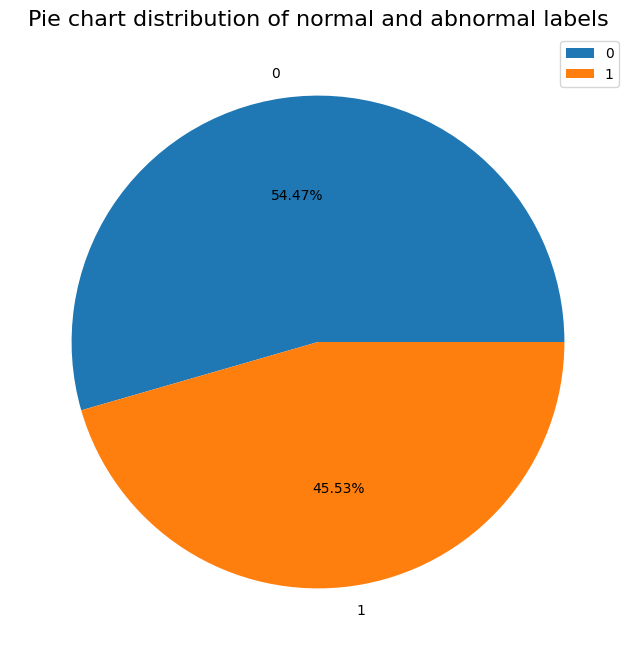

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(combined_df.type.value_counts(),labels=['0','1'],autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels",fontsize=16)
plt.legend()
# plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik1_Studi Transformer-Based Sequence Modelling untuk Deteksi Ransomware Melalui Analisis Trafik Jaringan yang Mengenkripsi Secara Tiba-tiba/plot/Pie_chart_binary2.png')
plt.show()

# Import Transformer

In [ ]:
!pip install transformers tensorflow

# GPT (Generative Pre-trained Transformer)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2Tokenizer, GPT2Model, GPT2ForSequenceClassification, TrainingArguments, Trainer

In [ ]:
# 1. Preprocessing: Label Encoding dan Normalization
le = LabelEncoder()
y_bin = le.fit_transform(combined_df['type'].values)  # Encode labels
class_names = le.classes_  # Save the original class names

In [ ]:
# Normalize feature data
scaler = StandardScaler()
X_bin = scaler.fit_transform(combined_df.drop(columns=['type']).values)

In [ ]:
# 2. Load GPT Model and Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=len(class_names))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Add a padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Tokenize the data
texts = combined_df.drop(columns=['type']).astype(str).apply(lambda x: ' '.join(x), axis=1).tolist()
tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

# Separate input_ids and attention_mask
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']

# Perform train-test split on each tensor and labels
train_input_ids, val_input_ids, train_attention_mask, val_attention_mask, y_train_bin, y_val_bin = train_test_split(
    input_ids, attention_mask, y_bin, test_size=0.2, random_state=50
)

# Package the tokens back into dictionaries for train and validation sets
train_tokens = {'input_ids': train_input_ids, 'attention_mask': train_attention_mask}
val_tokens = {'input_ids': val_input_ids, 'attention_mask': val_attention_mask}

In [ ]:
# 3. Define the Trainer with KFold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=50)
all_accuracy, all_f1_scores = [], []
conf_matrix_list = []

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

for fold, (train_index, val_index) in enumerate(kf.split(train_tokens["input_ids"])):
    print(f"Fold {fold + 1}")

        # Split data
    train_subset = {key: val[train_index] for key, val in train_tokens.items()}
    val_subset = {key: val[val_index] for key, val in val_tokens.items()}
    y_train, y_val = y_train_bin[train_index], y_val_bin[val_index]

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_fold_{fold + 1}',
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=(train_subset, y_train),
        eval_dataset=(val_subset, y_val),
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()
    metrics = trainer.evaluate()

    # Metrics calculation and storage
    all_accuracy.append(metrics["eval_accuracy"])
    all_f1_scores.append(metrics["eval_f1"])
    conf_matrix = confusion_matrix(y_val, np.argmax(metrics["eval_logits"], axis=1))
    conf_matrix_list.append(conf_matrix)

    # Print results for the current fold
    print(f"Accuracy for fold {fold + 1}: {metrics['eval_accuracy'] * 100:.2f}%")
    print(f"F1 Score for fold {fold + 1}: {metrics['eval_f1']:.4f}")
    print(classification_report(y_val, np.argmax(metrics["eval_logits"], axis=1), target_names=class_names))

    # Plot confusion matrix for the current fold
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.show()

In [ ]:
# 4. Average Metrics Across All Folds
print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')

In [ ]:
# 5. Plot the Average Confusion Matrix
average_conf_matrix = np.mean(conf_matrix_list, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix Across Folds')
plt.show()